In [74]:
import sys, platform

base_path = '/home/yurid/git/tcc'

if platform.system() == 'Darwin':
    base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)
base_path

'/home/yurid/git/tcc'

In [75]:
%pip install statsmodels

/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [76]:
from math import sqrt

import keras
import numpy as np
import pandas as pd
import optuna
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.impute import KNNImputer
import src.filler as fl
from src.filler import RandomForestFillerWithOneModel, LstmFillerModel, HodmdFiller, Debbuger
from src.dataframe import read_data_from_csv, show_error_metrics, split_data, windowing_nparray

In [77]:
filename = f'{base_path}/data/daily_vicosa.csv'

In [78]:
df = read_data_from_csv(filename)

df = df.RADIATION

In [79]:
data = fl.FillerHelper.get_largest_complete_interval(df)
data_with_gaps = fl.FillerHelper.introduce_gaps(data.copy(), 
                                                missing_percentage=0.01, 
                                                min_gap_size=5, 
                                                max_gap_size=40)

3839
751
Percentual de dados faltantes: 0.19562386038030738


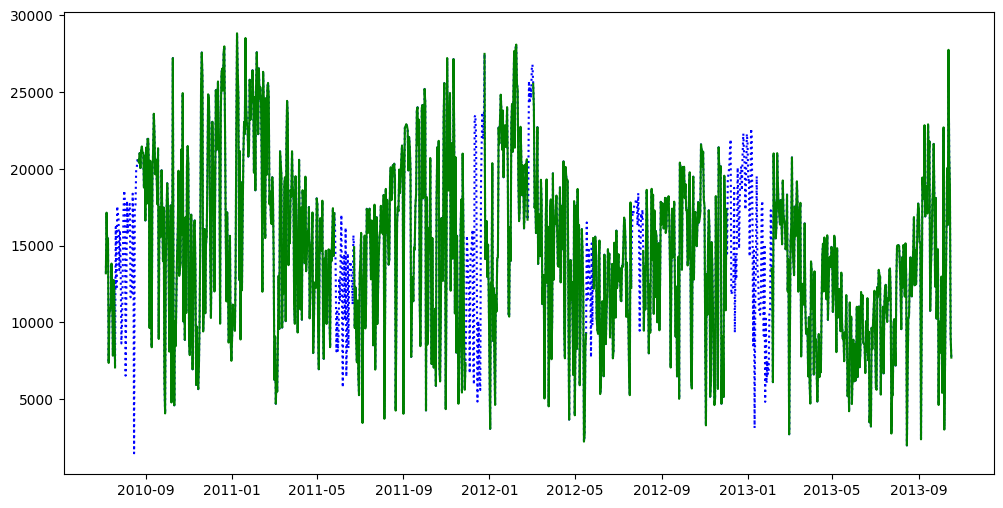

In [80]:
maxrange = 1200

print(len(data))
print(data_with_gaps.isna().sum())
print('Percentual de dados faltantes:', (data_with_gaps.isna().sum()/len(data)))

pyplot.figure(figsize=(12, 6))
pyplot.plot(data[0:maxrange], color = 'b', linestyle = ':')
pyplot.plot(data_with_gaps[0:maxrange], color='green', label='missing_data')
pyplot.show()

DMD

In [81]:
def objective(trial):
    dmd_data = data_with_gaps.copy()
    filler = fl.HodmdFiller(d_factor=trial.suggest_float("d_fator", 0.5, 0.99, log=True))
    data_filled = filler.dmd_filler(dmd_data)
    mae = mean_absolute_error(data, data_filled)
    print('MAE SCORE:', mae)
    return mae


study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///filler_method.db',
    study_name=f'hodmd',
    load_if_exists=True
)

n_trials = 8
if len(study.trials) < n_trials:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=600, 
        gc_after_trial=True,
        n_jobs=4
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-04 11:13:38,395] Using an existing study with name 'hodmd' instead of creating a new one.


Number of finished trials: 15
Best trial:
  Value: 1552.2483310419966
  Params: 
    d_fator: 0.8450333686112531
    factor: 0.8138850095355864


Interpolation Seasonal

In [82]:
def objective(trial):
    data_filled = fl.seasonal_filler(data_with_gaps.copy(), 
                                     period=trial.suggest_int("period", 24, 365, log=True), 
                                     factor=trial.suggest_int("factor", 1, 6, log=True))
    mae = mean_absolute_error(data, data_filled)
    print('MAE SCORE:', mae)
    print('Faltantes SCORE:', data_filled.isna().sum())
    return mae



study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///filler_method.db',
    study_name=f'interpolation_seasonal_new',
    load_if_exists=True
)

n_trials = 100
if len(study.trials) < n_trials:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=600, 
        gc_after_trial=True,
        n_jobs=4
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-04 11:13:38,524] Using an existing study with name 'interpolation_seasonal_new' instead of creating a new one.


Number of finished trials: 160
Best trial:
  Value: 1589.9163320628968
  Params: 
    period: 347
    factor: 6


Random forest

In [83]:
def objective(trial):
    rf_data = data_with_gaps.copy()
    filler_model = RandomForestFillerWithOneModel(
        n_estimators=trial.suggest_int("estimators", 100, 5000, log=True), 
        n_in=trial.suggest_int("n_in", 1, 15, log=True), 
        n_out=1)
    data_filled = filler_model.filler(rf_data)
    mae = mean_absolute_error(data, data_filled)
    print('MAE SCORE:', mae)
    print('Faltantes SCORE:', data_filled.isna().sum())
    return mae



study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///filler_method.db',
    study_name=f'random_forest',
    load_if_exists=True
)

n_trials = 40
if len(study.trials) < n_trials:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=600, 
        gc_after_trial=True,
        n_jobs=4
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-04 11:13:38,672] Using an existing study with name 'random_forest' instead of creating a new one.


Number of finished trials: 44
Best trial:
  Value: 896.0714458131623
  Params: 
    estimators: 1762
    n_in: 3


In [84]:
def windowing_nparray(values, step_back, step_front) -> (np.array, np.array):
    x, y = [], []
    for i in range(len(values) - step_back - step_front):
        j = (i + step_back)
        x.append(values[i:j])
        y.append(values[j:(j+step_front), 0])

    return np.array(x), np.array(y)

def knn_filler(data, k):
    imputer = KNNImputer(n_neighbors=k)
    filled_data_knn = imputer.fit_transform(data.values.reshape(-1,1))
    return pd.Series(filled_data_knn.ravel(), name=data.name, index=data.index.values)

def train_model(train_x, train_y, is_debug):
    model = Sequential([
        InputLayer(input_shape=(train_x.shape[1], train_x.shape[2])),
        LSTM(units=350),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam())

    Debbuger.log(is_debug, 'Model Summary', model.summary())

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

    history = model.fit(train_x,
                        train_y,
                        epochs=5000,
                        batch_size=32,
                        validation_split=0.2,
                        verbose=0,
                        callbacks=[es],
                        workers=4,
                        use_multiprocessing=True)

    # plot history
    if is_debug:
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()

    return model

In [85]:
step_back = 5
ratio = 0.7

scaler = MinMaxScaler(feature_range=(0,1))

data_scaled = scaler.fit_transform(data.values.reshape(-1,1))

X, Y = windowing_nparray(data_scaled, step_back=step_back, step_front=1)
train_x, train_y, test_x, test_y = split_data(X, Y, length=len(data_scaled), ratio=ratio)

real_test_y = scaler.inverse_transform(test_y.reshape(-1,1))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 350)               492800    
                                                                 
 dense_18 (Dense)            (None, 1)                 351       
                                                                 
Total params: 493151 (1.88 MB)
Trainable params: 493151 (1.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 46.
Epoch 66: early stopping


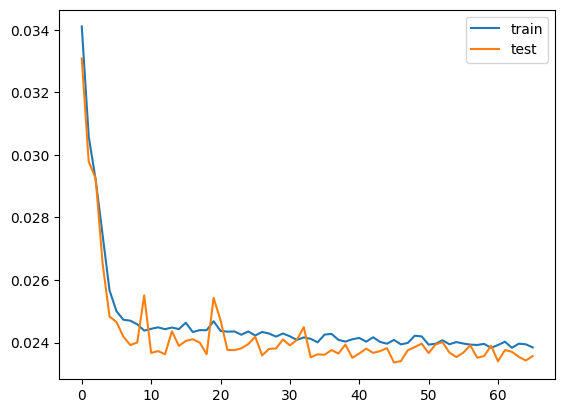

12/12 [==============================] - 0s 8ms/step
Forecasting
Test R2: 0.330
Test MSE: 21889826.477
Test RMSE: 4678.656
Test MAE: 3640.336
Test MAPE: 0.344


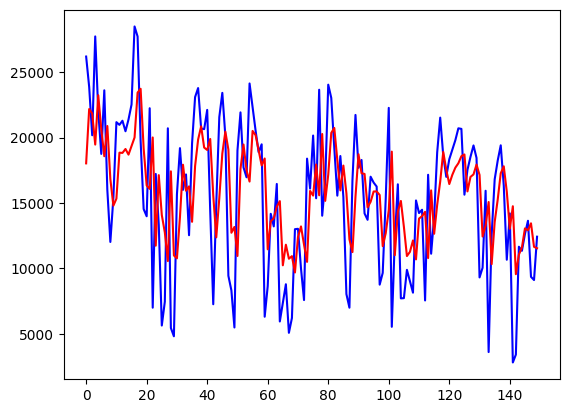

In [86]:
#Treinando model
model = train_model(train_x, train_y, True)
predict = model.predict(test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1,1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y.reshape(-1,1)[:range_plot], color='blue', label='Real')
pyplot.plot(predict.reshape(-1,1)[:range_plot], color='red', label='Previsão')
pyplot.show()

Input metrics
Test R2: -0.905
Test MSE: 65501503.650
Test RMSE: 8093.300
Test MAE: 3372.823
Test MAPE: 0.196


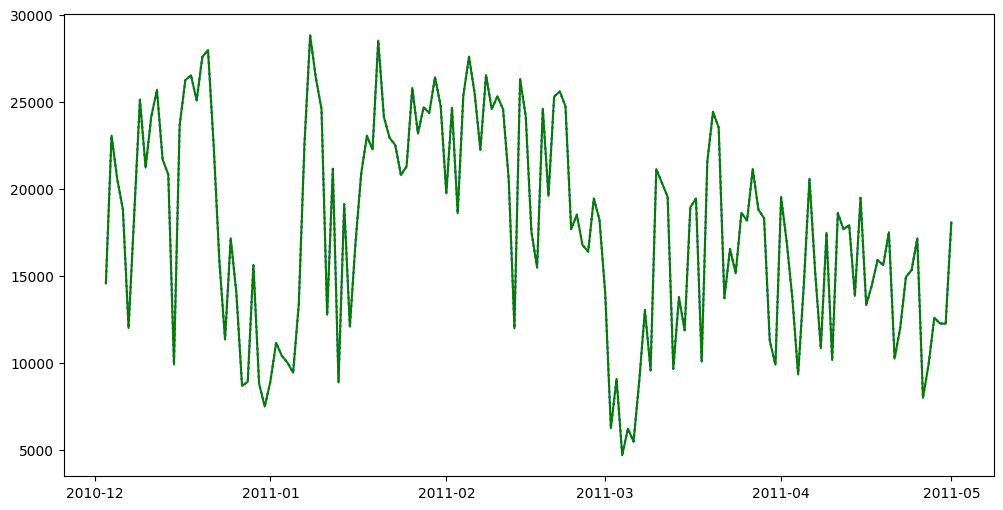

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 350)               492800    
                                                                 
 dense_19 (Dense)            (None, 1)                 351       
                                                                 
Total params: 493151 (1.88 MB)
Trainable params: 493151 (1.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 72.
Epoch 92: early stopping


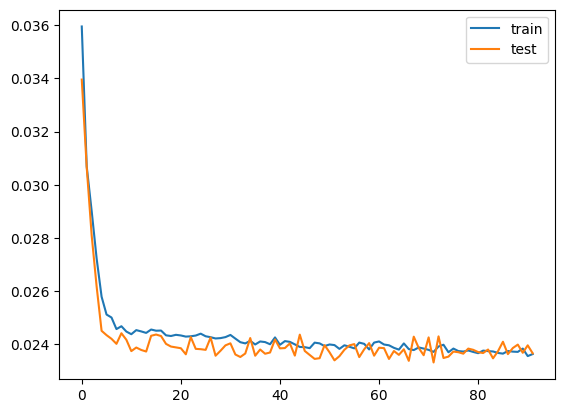

12/12 [==============================] - 0s 5ms/step
Forecasting
Test R2: 0.336
Test MSE: 21683709.616
Test RMSE: 4656.577
Test MAE: 3634.634
Test MAPE: 0.346


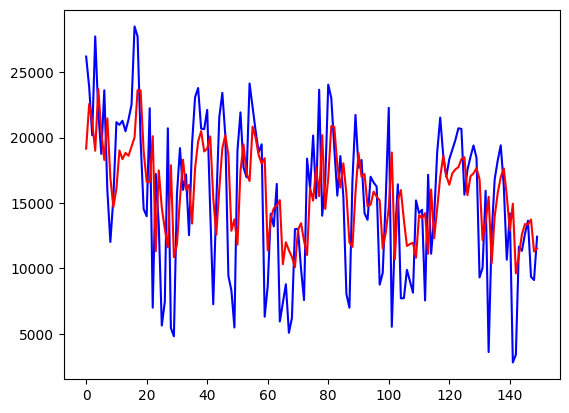

In [87]:
# Completa
data_gaps = data_with_gaps.copy()
data_gaps_filled = data_gaps.fillna(0)

# Métricas
print('Input metrics')
show_error_metrics(data, data_gaps_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(data_gaps_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
data_gaps_scaled = scaler.transform(data_gaps_filled.values.reshape(-1,1))
gaps_X, gaps_Y = windowing_nparray(data_gaps_scaled, step_back=step_back, step_front=1)
gaps_train_x, gaps_train_y, gaps_test_x, gaps_test_y = split_data(X, Y, length=len(data_gaps_scaled), ratio=ratio)

#Treinando model
model = train_model(gaps_train_x, gaps_train_y, True)
predict = model.predict(gaps_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1,1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y.reshape(-1,1)[:range_plot], color='blue', label='Real')
pyplot.plot(predict.reshape(-1,1)[:range_plot], color='red', label='Previsão')
pyplot.show()

(3839, 1)


/home/yurid/miniconda3/envs/tf/lib/python3.9/site-packages/pydmd/hodmd.py:140: UserWarning: The parameter 'svd_rank_extra=0' has been ignored because the given system is a scalar function
  warnings.warn(
/home/yurid/miniconda3/envs/tf/lib/python3.9/site-packages/pydmd/utils.py:35: RuntimeWarning: SVD optimal rank is 0. The largest singular values are indistinguishable from noise. Setting rank truncation to 1.
  warnings.warn(


DMDFiller -> Dados Faltantes: 0
Input metrics
Test R2: 0.723
Test MSE: 9515971.165
Test RMSE: 3084.797
Test MAE: 1093.253
Test MAPE: 0.086


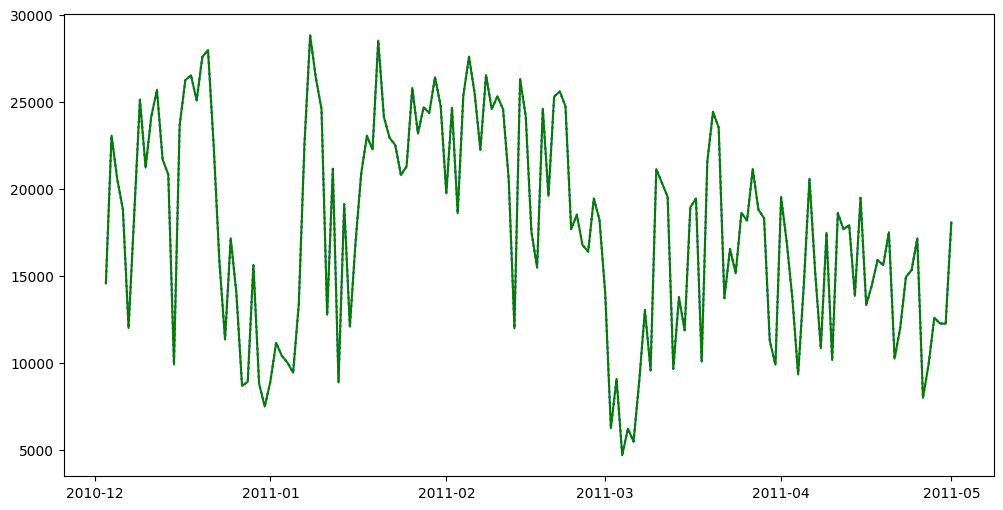

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 350)               492800    
                                                                 
 dense_20 (Dense)            (None, 1)                 351       
                                                                 
Total params: 493151 (1.88 MB)
Trainable params: 493151 (1.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 46.
Epoch 66: early stopping


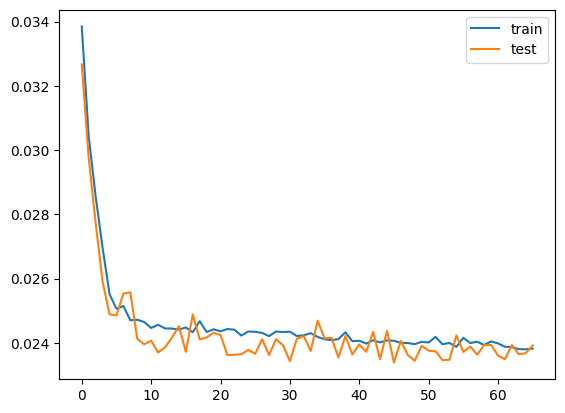

12/12 [==============================] - 0s 8ms/step
Forecasting
Test R2: 0.329
Test MSE: 21937159.956
Test RMSE: 4683.712
Test MAE: 3641.158
Test MAPE: 0.345


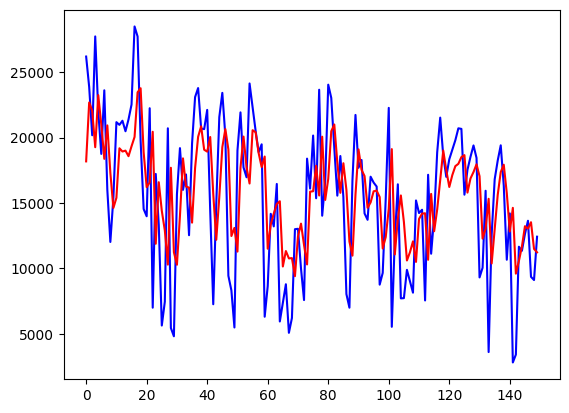

In [88]:
# Completa
dmd_data = data_with_gaps.copy()
filler = fl.HodmdFiller(d_factor=0.99)
data_filled = filler.dmd_filler(dmd_data)

# Métricas
print('Input metrics')
show_error_metrics(data, data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
dmd_data_scaled = scaler.transform(data_filled.values.reshape(-1,1))
dmd_X, dmd_Y = windowing_nparray(dmd_data_scaled, step_back=step_back, step_front=1)
dmd_train_x, dmd_train_y, dmd_test_x, dmd_test_y = split_data(X, Y, length=len(dmd_data_scaled), ratio=ratio)

#Treinando model
model = train_model(dmd_train_x, dmd_train_y, True)
predict = model.predict(dmd_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1,1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y.reshape(-1,1)[:range_plot], color='blue', label='Real')
pyplot.plot(predict.reshape(-1,1)[:range_plot], color='red', label='Previsão')
pyplot.show()

751
Input metrics
Test R2: 0.208
Test MSE: 27221055.925
Test RMSE: 5217.380
Test MAE: 1917.613
Test MAPE: 0.120


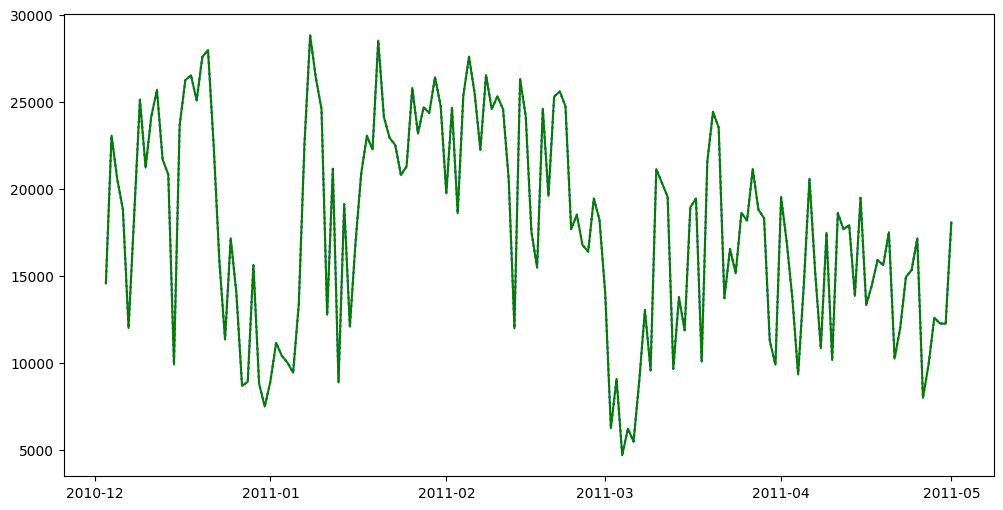

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 350)               492800    
                                                                 
 dense_21 (Dense)            (None, 1)                 351       
                                                                 
Total params: 493151 (1.88 MB)
Trainable params: 493151 (1.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 65.
Epoch 85: early stopping


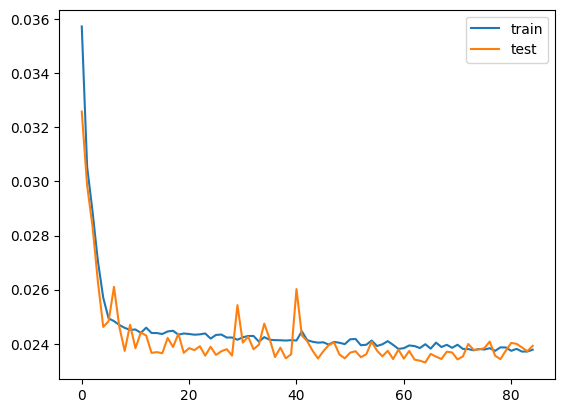

12/12 [==============================] - 0s 11ms/step
Forecasting
Test R2: 0.333
Test MSE: 21789695.886
Test RMSE: 4667.943
Test MAE: 3649.674
Test MAPE: 0.344


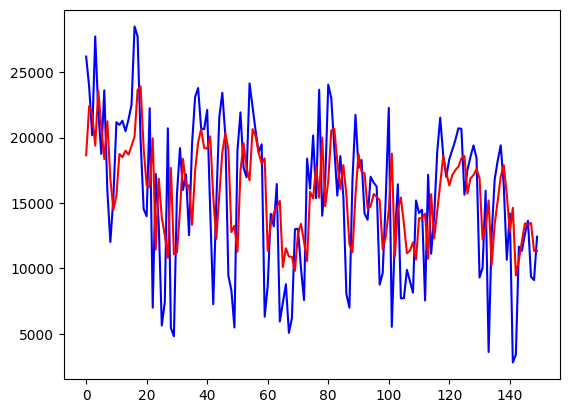

In [89]:
# Completa
seasonal_data = data_with_gaps.copy()
seasonal_data_filled = fl.seasonal_filler(seasonal_data, 
                                            period=347, 
                                            factor=6)

# Métricas
print('Input metrics')
show_error_metrics(data, seasonal_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(seasonal_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
seasonal_data_scaled = scaler.transform(seasonal_data_filled.values.reshape(-1,1))
seasonal_X, seasonal_Y = windowing_nparray(seasonal_data_scaled, step_back=step_back, step_front=1)
seasonal_train_x, seasonal_train_y, seasonal_test_x, seasonal_test_y = split_data(X, Y, length=len(seasonal_data_scaled), ratio=ratio)

#Treinando model
model = train_model(seasonal_train_x, seasonal_train_y, True)
predict = model.predict(seasonal_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()

Input metrics
Test R2: 0.689
Test MSE: 10688094.241
Test RMSE: 3269.265
Test MAE: 1192.517
Test MAPE: 0.080


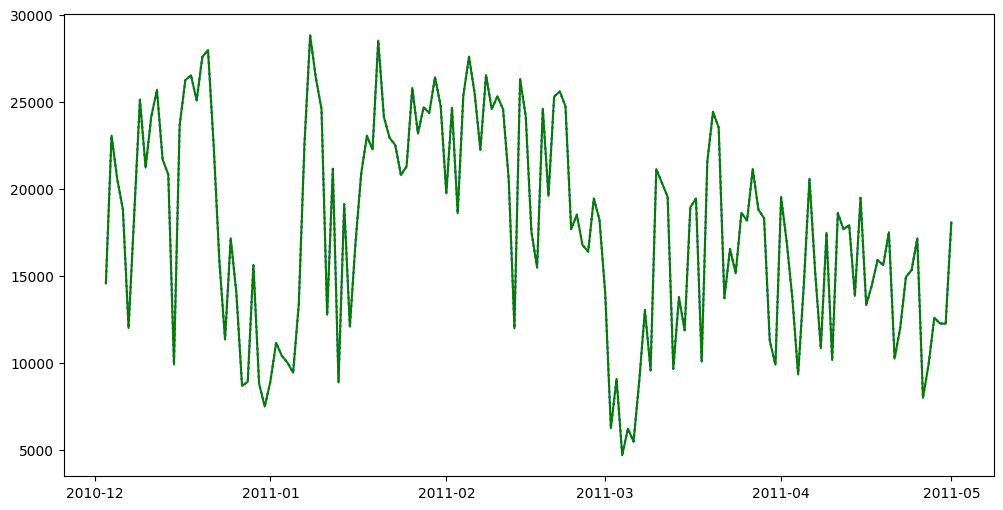

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 350)               492800    
                                                                 
 dense_22 (Dense)            (None, 1)                 351       
                                                                 
Total params: 493151 (1.88 MB)
Trainable params: 493151 (1.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 45.
Epoch 65: early stopping


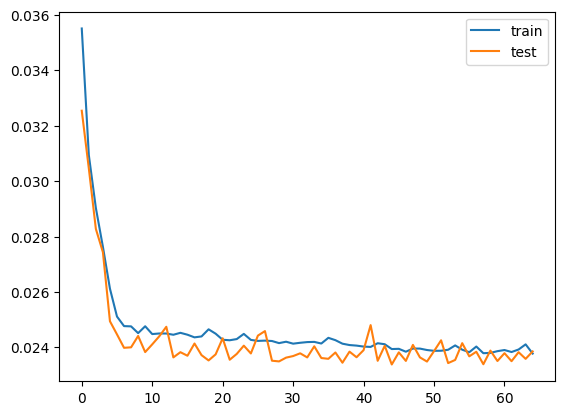

12/12 [==============================] - 0s 4ms/step
Forecasting
Test R2: 0.335
Test MSE: 21734555.818
Test RMSE: 4662.033
Test MAE: 3658.421
Test MAPE: 0.343


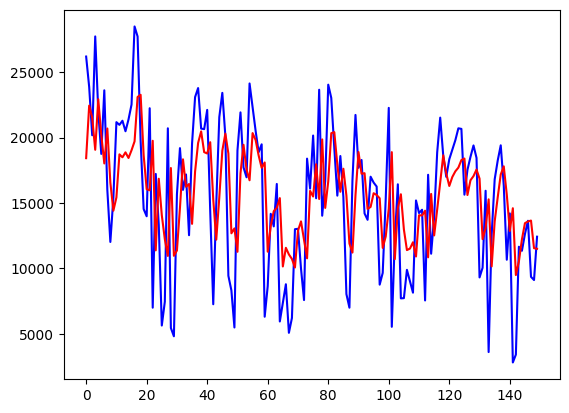

In [90]:
# Completa
rf_data = data_with_gaps.copy()
filler_model = RandomForestFillerWithOneModel(
    n_estimators=1500, 
    n_in=3, 
    n_out=1)
rf_data_filled = filler_model.filler(rf_data)

# Métricas
print('Input metrics')
show_error_metrics(data, rf_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(rf_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
rf_data_scaled = scaler.transform(rf_data_filled.values.reshape(-1,1))
rf_X, rf_Y = windowing_nparray(rf_data_scaled, step_back=step_back, step_front=1)
rf_train_x, rf_train_y, rf_test_x, rf_test_y = split_data(X, Y, length=len(rf_data_scaled), ratio=ratio)

#Treinando model
model = train_model(rf_train_x, rf_train_y, True)
predict = model.predict(rf_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()

Input metrics
Test R2: 0.776
Test MSE: 7711696.693
Test RMSE: 2776.994
Test MAE: 956.736
Test MAPE: 0.078


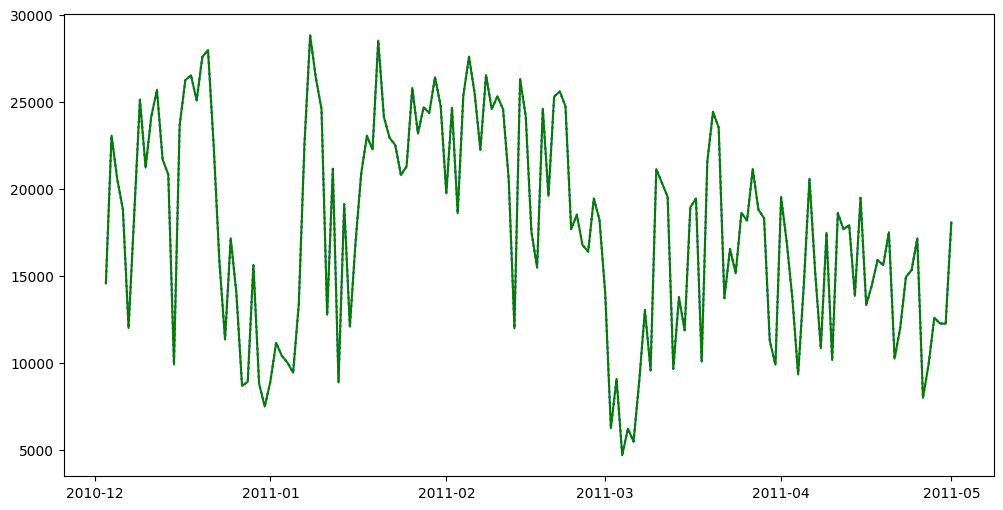

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 350)               492800    
                                                                 
 dense_23 (Dense)            (None, 1)                 351       
                                                                 
Total params: 493151 (1.88 MB)
Trainable params: 493151 (1.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 62.
Epoch 82: early stopping


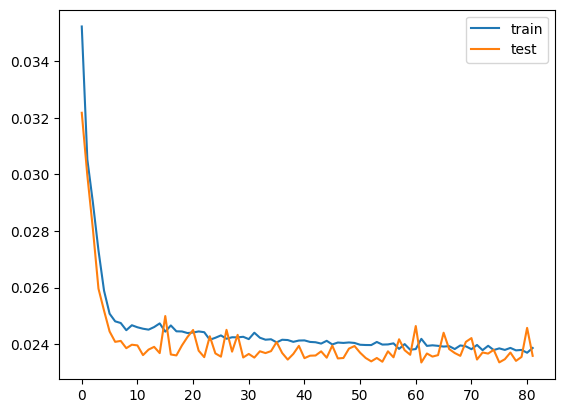

12/12 [==============================] - 0s 5ms/step
Forecasting
Test R2: 0.330
Test MSE: 21888762.622
Test RMSE: 4678.543
Test MAE: 3667.393
Test MAPE: 0.345


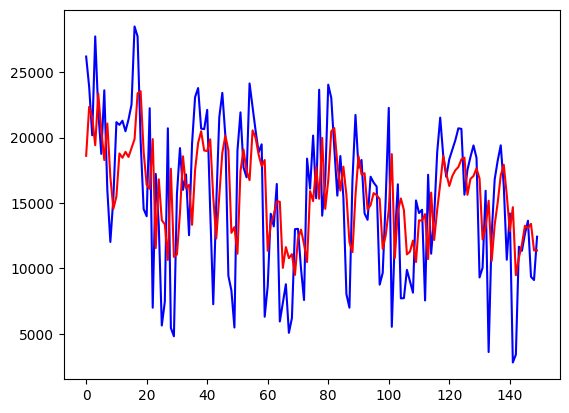

In [91]:
# Completa
interpolate_data = data_with_gaps.copy()
interpolate_data_filled = interpolate_data.interpolate(method='linear')

# Métricas
print('Input metrics')
show_error_metrics(data, interpolate_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(interpolate_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
interpolate_data_scaled = scaler.transform(interpolate_data_filled.values.reshape(-1,1))
interpolate_X, interpolate_Y = windowing_nparray(interpolate_data_scaled, step_back=step_back, step_front=1)
interpolate_train_x, interpolate_train_y, interpolate_test_x, interpolate_test_y = split_data(X, Y, length=len(interpolate_data_scaled), ratio=ratio)

#Treinando model
model = train_model(interpolate_train_x, interpolate_train_y, True)
predict = model.predict(interpolate_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()

Input metrics
Test R2: 0.775
Test MSE: 7754219.185
Test RMSE: 2784.640
Test MAE: 1023.335
Test MAPE: 0.081


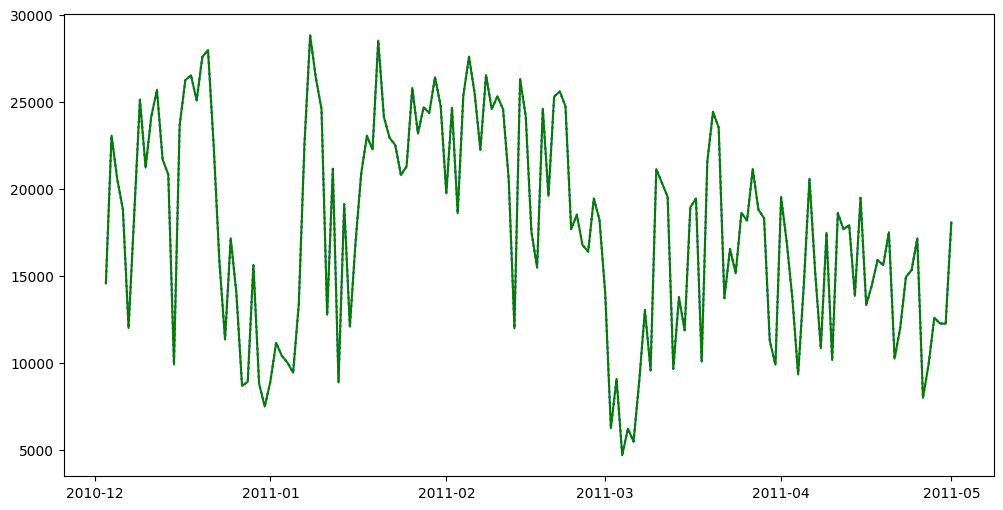

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 350)               492800    
                                                                 
 dense_24 (Dense)            (None, 1)                 351       
                                                                 
Total params: 493151 (1.88 MB)
Trainable params: 493151 (1.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 54.
Epoch 74: early stopping


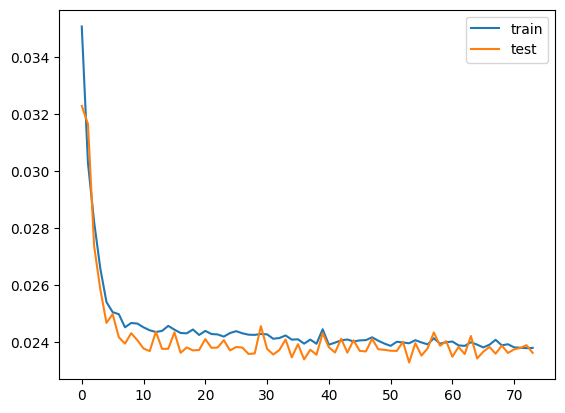

12/12 [==============================] - 0s 5ms/step
Forecasting
Test R2: 0.333
Test MSE: 21776250.962
Test RMSE: 4666.503
Test MAE: 3629.605
Test MAPE: 0.346


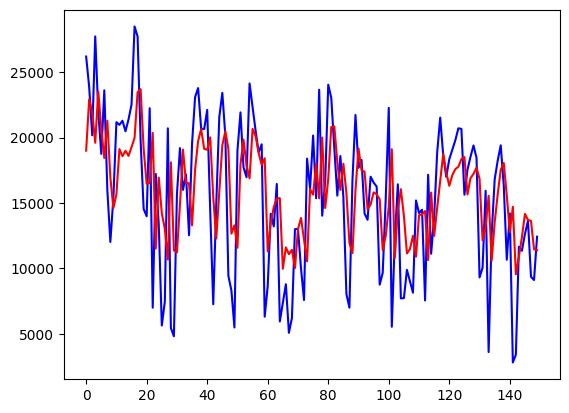

In [92]:
# Completa
knn_data = data_with_gaps.copy()
knn_data_filled = knn_filler(knn_data, k=5)

# Métricas
print('Input metrics')
show_error_metrics(data, knn_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(knn_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
knn_data_scaled = scaler.transform(knn_data_filled.values.reshape(-1,1))
knn_X, knn_Y = windowing_nparray(knn_data_scaled, step_back=step_back, step_front=1)
knn_train_x, knn_train_y, knn_test_x, knn_test_y = split_data(X, Y, length=len(knn_data_scaled), ratio=ratio)

#Treinando model
model = train_model(knn_train_x, knn_train_y, True)
predict = model.predict(knn_test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()